# Data Science 1 - Signal analysis

## Lesson 3 - Curve fitting

&copy; 2021, dr.ir. Dave R.M. Langers (LADR, ZP11/H1.90, [d.r.m.langers@pl.hanze.nl](mailto:d.r.m.langers@pl.hanze.nl))

<img src="https://bioinf.nl/~davelangers/dave.png" width="10%" height="10%" alt="Dave Langers" /> 

<small>**Note:** step forward using `SPACE` or backward using `SHIFT`+`SPACE`, or use the arrows in the bottom right to navigate; run code cells using `CTRL`+`ENTER`.</small>

------------------

# DIFFICULTIES:
- EXERCISE 5
------------

In [1]:
# Initialization

%matplotlib inline
import matplotlib.pyplot as plt, numpy as np, pandas as pd
from IPython.display import display
from lesson3 import figure

### Main material

*Numerical methods in engineering with python 3*, **chapter 3.4**

<img src="https://images-na.ssl-images-amazon.com/images/I/51963RBvJDL._SX348_BO1,204,203,200_.jpg" width="5%" height="5%" alt="Numerical methods in engineering with python 3" />

*Hands-on Signal Analysis with Python: An Introduction*, **chapter 5.4.1, 5.5.1, 8.3.1-2, 8.4.1-4 & 8.5.1-3**

<img src="https://images-na.ssl-images-amazon.com/images/I/41CaMa-FgDS._SX375_BO1,204,203,200_.jpg" width="5%" height="5%" alt="Hands-on Signal Analysis with Python: An Introduction" />

### <a id="/1">Lesson 3 - Curve fitting</a>

* <u>Part 3A</u><br />*Introduction*

* <span style="color:#336699"><a href="#/6">Part 3B</a><br />Polynomial regression</span>

* <span style="color:#336699"><a href="#/11">Part 3C</a><br />Confidence intervals</span>

* <span style="color:#336699"><a href="#/16">Part 3D</a><br />Savitsky-Golay</span>

### Interpolation versus Curve fitting

* [Interpolation](https://en.wikipedia.org/wiki/Interpolation) fits a function $y(x)$ through a set of data $(x_i, y_i)$ in such a way that $y(x_i)$ *exactly* reproduces $x_i$.<br />
  I.e., data are assumed to have no error.

* [Curve fitting](https://en.wikipedia.org/wiki/Curve_fitting) allows the function $y(x)$ to *approximate* a set of data $(x_i, y_i)$ such that $y(x_i) \approx y_i$.<br />
  I.e., data are assumed to have some error.

Curve fitting finds a [smooth](https://en.wikipedia.org/wiki/Smoothing) function that fits the data *on average*. It is a [regression](https://en.wikipedia.org/wiki/Regression_analysis) technique.


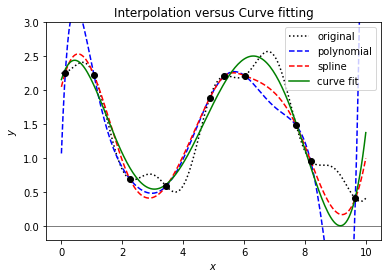

Figure 1: Interpolation versus Curve fitting


In [2]:
figure(1)

Because the fitted function does not exactly fit the data, some [residuals](https://en.wikipedia.org/wiki/Errors_and_residuals) $e_i$ are introduced.

$$
y_i = y(x_i) + e_i
$$

A common way to [optimize](https://en.wikipedia.org/wiki/Optimization_problem) the fit is to choose the parameters of the function $y(x)$ such that it minimizes the [residual sum of squares](https://en.wikipedia.org/wiki/Residual_sum_of_squares) $S$.

$$
S = \sum_{i=1}^n e_i^2 = \sum_{i=1}^n \left( y_i - y(x_i) \right) ^2
$$

This is refered to as [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) (OLS) regression. The measure $S$ penalizes bad fits and acts as a [cost function](https://en.wikipedia.org/wiki/Loss_function).

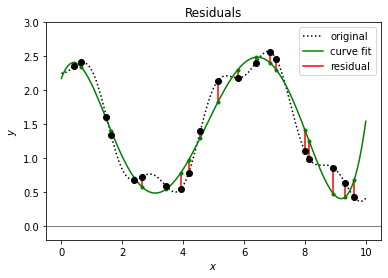

Figure 2: Residuals


In [3]:
figure(2)

### Linear regression

If the model function $y(x)$ can be written as a linear combination of specified functions $f_i(x)$

$$
y(x) = \sum_{j=0}^p a_j \cdot f_j(x) = a_0 \cdot f_0(x) + a_1 \cdot f_1(x) + \ldots + a_p \cdot f_p(x)
$$

then we can write

$$
\left[\begin{array}{c}
y_1\\
y_2\\
\vdots\\
y_n
\end{array}\right]=\left[\begin{array}{cccc}
f_0(x_1) & f_1(x_1) & \cdots & f_p(x_1) \\
f_0(x_2) & f_1(x_2) & \cdots & f_p(x_2) \\
\vdots & \vdots & \ddots & \vdots\\
f_0(x_n) & f_1(x_n) & \cdots & f_p(x_n)
\end{array}\right]\left[\begin{array}{c}
a_0\\
a_1\\
\vdots\\
a_p
\end{array}\right] + \left[\begin{array}{c}
e_0\\
e_1\\
\vdots\\
e_n
\end{array}\right]
$$

Or, equivalently, $\boldsymbol{y} = \boldsymbol{X} \boldsymbol{a} + \boldsymbol{e}$ where the [design matrix](https://en.wikipedia.org/wiki/Design_matrix) $\boldsymbol{X}$ is defined by $X_{ij} = f_j(x_i)$. Typically, $\boldsymbol{X}$ is a tall matrix (as opposed to being square for polynomial interpolation).

In the case of a polynomial function $y(x)$, the basis functions equal $f_j(x)=x^j$. The model equations become

$$
\left[\begin{array}{c}
y_1\\
y_2\\
\vdots\\
y_n
\end{array}\right]=\left[\begin{array}{cccc}
x_1^p & \cdots & x_1 & 1 \\
x_2^p & \cdots & x_2 & 1 \\
\vdots & \ddots & \vdots & \vdots\\
x_n^p & \cdots & x_n & 1
\end{array}\right]\left[\begin{array}{c}
a_p\\
\vdots\\
a_1\\
a_0
\end{array}\right] + \left[\begin{array}{c}
e_0\\
e_1\\
\vdots\\
e_n
\end{array}\right]
$$

The design matrix $\boldsymbol{X}$ in $\boldsymbol{y} = \boldsymbol{X} \boldsymbol{a} + \boldsymbol{e}$ then is a [Vandermonde matrix](https://en.wikipedia.org/wiki/Vandermonde_matrix).

Using vector notation, the sum of squares reduces to $S = \sum_{i=1}^n e_i^2 = \| \boldsymbol{e} \| = \boldsymbol{e}^\text{T}\boldsymbol{e} = (\boldsymbol{y} - \boldsymbol{X} \boldsymbol{a})^\text{T} (\boldsymbol{y} - \boldsymbol{X} \boldsymbol{a})$. Thus, $S$ is a function of all unknown $a_j$.

Least squares minimization amounts to finding the parameters $\boldsymbol{a}$ where all $\frac{\partial S}{\partial a_j}=0$. This leads to a system of linear equations that can be solved using linear algebra.

The general solution equals

$$
\boldsymbol{a} = (\boldsymbol{X}^\text{T}\boldsymbol{X})^{-1} \cdot \boldsymbol{X}^\text{T} \boldsymbol{y}
$$

This equation is worth remembering.

<small>**Note:** see also Eq. 8.15 on P.144 of *Hands-on Signal Analysis with Python: An Introduction* (with slightly different notation).</small>

### Example

Consider the following data regarding the monthly number of confirmed Covid cases in the municipality of Groningen (from: [Coronavirus Dashboard](https://coronadashboard.government.nl/landelijk/positief-geteste-mensen)).

| Year | Month | Cases |   | Year | Month | Cases |
| ---- | ----- | ----- | - | ---- | ----- | ----- |
| 2020 | -     | -     |   | 2021 | Jan   | 1399  |
|      | Mar   | 92    |   |      | Mar   | 1590  |
|      | May   | 7     |   |      | May   | 1261  |
|      | Jul   | 16    |   |      | Jul   | 5690  |
|      | Sep   | 885   |   |      | Sep   | 670   |
|      | Nov   | 849   |   |      | Nov   | 3271  |

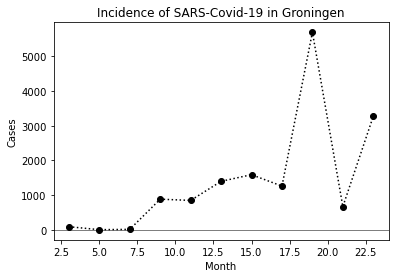

In [4]:
months = np.arange(3, 24, 2)
cases = np.array([
    92, 7, 16, 885, 849,
    1399, 1590, 1261, 5690, 670, 3271
])

plt.axhline(0.0, color='k', lw=0.5)
plt.plot(months, cases, 'o:k')
plt.xlabel('Month'); plt.ylabel('Cases')
plt.title('Incidence of SARS-Covid-19 in Groningen')
plt.show()

The `numpy` module provides the `polyfit()` function that implements polynomial curve fitting. Required arguments are vectors $\boldsymbol{x}$ and $\boldsymbol{y}$, as well as the degree `deg` of the requested polynomial.

In [3]:
help(np.polyfit)

Help on function polyfit in module numpy:

polyfit(x, y, deg, rcond=None, full=False, w=None, cov=False)
    Least squares polynomial fit.
    
    .. note::
       This forms part of the old polynomial API. Since version 1.4, the
       new polynomial API defined in `numpy.polynomial` is preferred.
       A summary of the differences can be found in the
       :doc:`transition guide </reference/routines.polynomials>`.
    
    Fit a polynomial ``p(x) = p[0] * x**deg + ... + p[deg]`` of degree `deg`
    to points `(x, y)`. Returns a vector of coefficients `p` that minimises
    the squared error in the order `deg`, `deg-1`, ... `0`.
    
    The `Polynomial.fit <numpy.polynomial.polynomial.Polynomial.fit>` class
    method is recommended for new code as it is more stable numerically. See
    the documentation of the method for more information.
    
    Parameters
    ----------
    x : array_like, shape (M,)
        x-coordinates of the M sample points ``(x[i], y[i])``.
    y : array_

The `polyfit()` function returns the coefficients of the polynomial as an array.

Below we construct a *linear* approximation to the available data.

In [4]:
coef = np.polyfit(months, cases, deg=1)
coef

array([ 168.46363636, -760.02727273])

Therefore, to two decimals accuracy, $a_1 = 168.46$ and $a_0 = -760.03$, such that $y(x) = 168.46 x - 760.03$. 

Unlike the return values of the `lagrange()` and `interp1d()` functions, `polyfit()` does not return a callable polynomial function. However, we can calculate function values from the coefficients using the `polyval()` function.

In [5]:
np.polyval(coef, 12.0)

1261.5363636363631

Alternatively, a callable `poly1d` object can be constructed from the coefficients that behaves like a function.

In [6]:
curvefit = np.poly1d(coef)
type(curvefit)

numpy.poly1d

In [7]:
curvefit(12.0)

1261.5363636363631

When we fit the number of cases for intermediate months in 2020 and 2021, we observe that the measured data are no longer exactly reproduced by the interpolant. Nevertheless, the line captures the trend in the increasing number of cases.

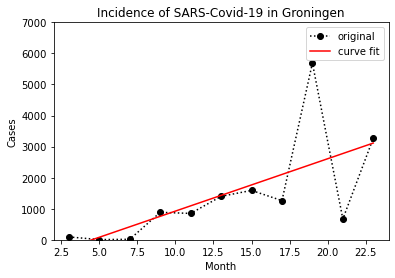

In [8]:
x = np.linspace(3, 23, 101)
y = curvefit(x)

plt.axhline(0.0, color='k', lw=0.5)
plt.plot(months, cases, 'o:k', label='original')
plt.plot(x, y, '-r', label='curve fit')
plt.xlabel('Month'); plt.ylabel('Cases')
plt.title('Incidence of SARS-Covid-19 in Groningen')
plt.legend(); plt.ylim(0.0, 7.0e3); plt.show()

### Other useful functions

In addition to `polyfit()`, the `numpy.linalg` module also contains the `lstsq()` function. Apart from the measured signal $\boldsymbol{y}$, it requires the design matrix $\boldsymbol{X}$ to be specified instead of the $\boldsymbol{x}$ themselves. Therefore, it is not limited to polynomial curves of specified degree, but can fit *any* linear model.

<small>**Note:** the `scipy.linalg` module contains an almost identical `lstsq()` function that has some extra options that are rarely used.</small>

Below, we use it to fit a model $y(x) = a_2 x^2 + a_1 x$ that has linear and quadratic terms, but no constant offset. We first construct the design matrix $\boldsymbol{X}$.

In [9]:
design = np.vstack((months ** 2, months)).T
design

array([[  9,   3],
       [ 25,   5],
       [ 49,   7],
       [ 81,   9],
       [121,  11],
       [169,  13],
       [225,  15],
       [289,  17],
       [361,  19],
       [441,  21],
       [529,  23]])

The model can be fitted using the `lstsq()` function.

In addition to the desired coefficients, this function returns various diagnostic outcomes; these are ignored below.

<small>**Note:** the argument `rcond=None` is added here to avoid a warning in some versions of `numpy`.</small>

In [10]:
coef, *_ = np.linalg.lstsq(design, cases, rcond=None)
coef

array([ 4.23167104, 45.12037022])

Therefore, the fitted polynomial without intercept equals

$$
y(x) = 4.23 x^2 + 45.12 x
$$

to two decimals accuracy.

When we plot the curve fit, again it does not pass through any of the data points exactly, but it captures the increasing trend. Now, a weak upwards curvature is noticable in the trend curve.

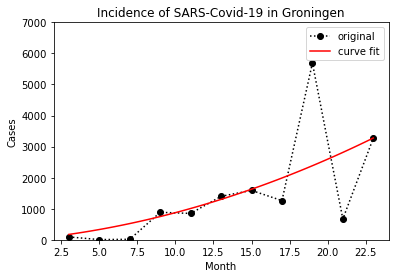

In [11]:
x = np.linspace(3, 23, 101)
y = coef[0] * x ** 2 + coef[1] * x

plt.axhline(0.0, color='k', lw=0.5)
plt.plot(months, cases, 'o:k', label='original')
plt.plot(x, y, '-r', label='curve fit')
plt.xlabel('Month'); plt.ylabel('Cases')
plt.title('Incidence of SARS-Covid-19 in Groningen')
plt.legend(); plt.ylim(0.0, 7.0e3); plt.show()

### Exercise 1

We wish to fit the number of SARS-Covid-19 cases using an exponential growth model.

$$
N(t) = N_0 \cdot 2^\frac{t}{\tau}
$$

where $N_0$ is the initial number of cases at $t=0$, and $\tau$ is the doubling time.

This model cannot be fitted using linear curve fitting methods because the parameter $\tau$ occurs in the exponent rather than as a coefficient. However, using a logarithmic transformation, we can express $\ln N(t)$ linearly in terms of $t$.

$$
\ln{N(t)} = \ln N_0 + \frac{\ln 2}{\tau} \cdot t = a_0 + a_1 \cdot t
$$

Find the coefficients of this linearized model and use them to estimate the doubling time $\tau$ of the virus over the measured period.

In [6]:
design = np.vstack((np.ones(months.size), months)).T
design

array([[ 1.,  3.],
       [ 1.,  5.],
       [ 1.,  7.],
       [ 1.,  9.],
       [ 1., 11.],
       [ 1., 13.],
       [ 1., 15.],
       [ 1., 17.],
       [ 1., 19.],
       [ 1., 21.],
       [ 1., 23.]])

In [17]:
# way 1
coef, *_ = np.linalg.lstsq(design, np.log2(cases), rcond=None)
coef = np.exp2(coef)
print(coef)

# way 2
coef = np.polyfit(months, np.log2(cases), deg=1)
print(coef)
f = np.poly1d(coef)

[18.31262641  1.28436391]
[0.36105403 4.19476681]


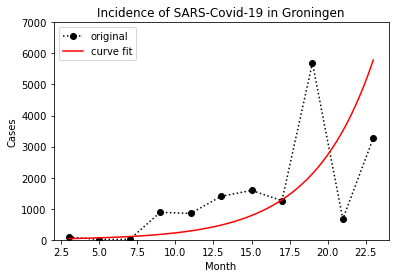

In [18]:
x = np.linspace(3, 23, 101)

# y = coef[1] * coef[0]*x
y = np.exp2(f(x))

plt.axhline(0.0, color='k', lw=0.5)
plt.plot(months, cases, 'o:k', label='original')
plt.plot(x, y, '-r', label='curve fit')
plt.xlabel('Month'); plt.ylabel('Cases')
plt.title('Incidence of SARS-Covid-19 in Groningen')
plt.legend(); plt.ylim(0.0, 7.0e3); plt.show()

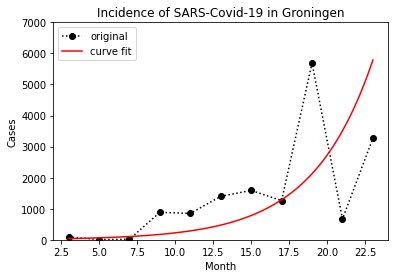

τ = 2.770 months


### Exercise 2

Earth's surface continues to significantly warm, with recent global temperatures being the hottest in the past 2000+ years.

<img src="https://climate.nasa.gov/system/content_pages/main_images/1309_compare_obs_2020_768px.jpg" width="20%" height="20%" alt="Temperature anomaly" />

The following code snippet extracts data regarding the change in global surface temperature relative to 1951-1980 average temperatures (from: [NASA](https://climate.nasa.gov/vital-signs/global-temperature/)) into a `pandas` dataframe named `population`.

```python
url = 'https://data.giss.nasa.gov/gistemp/graphs/graph_data/Global_Mean_Estimates_based_on_Land_and_Ocean_Data/graph.txt'
climate = pd.read_csv(url, delim_whitespace=True, skiprows=5,
                      usecols=[0, 1], index_col=0, names=['Year', 'Anomaly [°C]'])
```

Plot the global temperature together with a cubic polynomial curve fit, extrapolated until 2050.

In [27]:
url = 'https://data.giss.nasa.gov/gistemp/graphs/graph_data/Global_Mean_Estimates_based_on_Land_and_Ocean_Data/graph.txt'
climate = pd.read_csv(url, delim_whitespace=True, skiprows=5,
                      usecols=[0, 1], index_col=0, names=['Year', 'Anomaly [°C]'])

climate.head()

,Anomaly [°C]
Year,
1880,-0.16
1881,-0.08
1882,-0.11
1883,-0.17
1884,-0.28


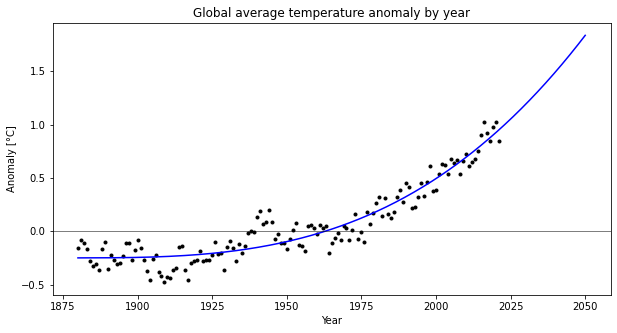

In [45]:
xi, yi = climate.index, climate['Anomaly [°C]']

coef = np.polyfit(xi, yi, deg=3)
x = np.linspace(1880, 2050, 501)
y = np.polyval(coef, x)

plt.figure(figsize=(10, 5))

plt.plot(xi, yi, 'ok', markersize=3)
plt.plot(x, y, '-b', label='curve fit')

plt.axhline(y=0, color='black', lw=0.5)

plt.ylabel('Anomaly [°C]')
plt.xlabel('Year')
plt.title('Global average temperature anomaly by year')

plt.show()

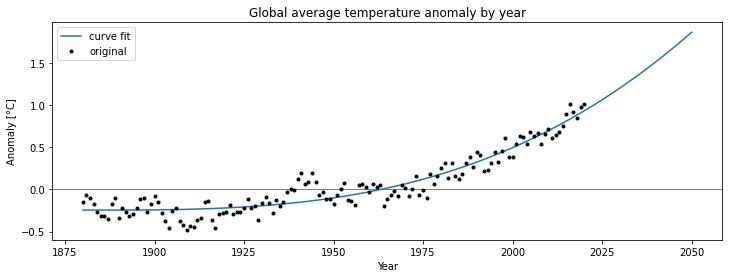

### Exercise 3

The [phon scale](https://en.wikipedia.org/wiki/Phon) is a scale that quantifies the subjective loudness of sounds. The below code fragment loads the [equal loudness contours](https://en.wikipedia.org/wiki/Equal-loudness_contour) of human hearing (from: [Lawrence Yule](https://chart-studio.plotly.com/~mrlyule)).

```python
url = 'https://chart-studio.plotly.com/~mrlyule/16.csv'
loudness = pd.read_csv(url, skiprows=1, index_col=0)
loudness = loudness.iloc[:-1].drop(columns='10')
```

For sound frequencies from 20 Hz to 16 kHz, the sound level (in decibel Sound Pressure Level, dB SPL) that is required to evoke a perceptual loudness of 0 to 100 phons in steps of 20 phons is listed.
 
Plot all of these data series together with their quadratic curve fits. Use a logarithmic frequency axis, both for modelling and plotting these data.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = 'https://chart-studio.plotly.com/~mrlyule/16.csv'
loudness = pd.read_csv(url, skiprows=1, index_col=0)
loudness = loudness.iloc[:-1].drop(columns='10')
loudness.head()

,0,20,40,60,80,100
frequency,,,,,,
20.0,76.55,89.58,99.85,109.51,118.99,128.41
25.0,65.62,82.65,93.94,104.23,114.23,124.15
31.5,55.12,75.98,88.17,99.08,109.65,120.11
40.0,45.53,69.62,82.63,94.18,105.34,116.38
50.0,37.63,64.02,77.78,89.96,101.72,113.35


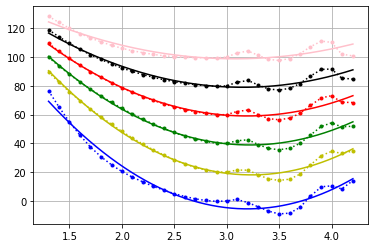

In [8]:
xi = np.log10(loudness.index)
x = np.log10(np.linspace(20, 16000, 20000))
columns = loudness.columns
colors = ['b', 'y', 'g', 'r', 'k', 'pink']


for i, col in enumerate(columns):
    coef = np.polyfit(np.log10(loudness.index), loudness[col], deg=2)
    fit = np.poly1d(coef)
    y = fit(x)
    
    plt.plot(xi, loudness[col], ':o', color=colors[i], markersize=3)
    plt.plot(x, y, '-', color=colors[i])
    
plt.grid()
plt.show()

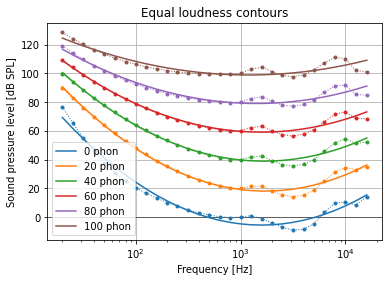

### Exercise 4

Below, some observations are provided regarding the size of a moose population in Michigan (from: [Wolves & Moose from Isle Royal](https://isleroyalewolf.org/data/data/home.html)).

```python
years = np.arange(1959, 2020)
moose = np.array([
    538, 564, 572, 579, 596, 620, 634, 661, 766, 848, 1041, 1045, 1183,
    1243,1215, 1203, 1139, 1070, 949, 845, 857, 788, 767, 780, 830, 927,
    976, 1014, 1046, 1116, 1260, 1315, 1496, 1697, 1784, 2017, 2117,
    2398, 900, 925, 997, 1031, 1120, 1100, 900, 750, 540, 450, 385,
    650, 530, 510, 515, 750, 975, 1050, 1250, 1300, 1600, 1475, 2060
])
```

Plot the population across the available years together with a trendline based on a polynomial curve fit. Choose the degree of the polynomial such that it fits the main features of the data reasonably well. Does it make a difference whether you encode the year as a 4-digit integer (i.e. $t=1959 \ldots 2019$) or as an offset relative to the year 2000 (i.e. $t=-41 \ldots 19$)?

In [19]:
years = np.arange(1959, 2020)
moose = np.array([
    538, 564, 572, 579, 596, 620, 634, 661, 766, 848, 1041, 1045, 1183,
    1243,1215, 1203, 1139, 1070, 949, 845, 857, 788, 767, 780, 830, 927,
    976, 1014, 1046, 1116, 1260, 1315, 1496, 1697, 1784, 2017, 2117,
    2398, 900, 925, 997, 1031, 1120, 1100, 900, 750, 540, 450, 385,
    650, 530, 510, 515, 750, 975, 1050, 1250, 1300, 1600, 1475, 2060
])

In [23]:
coef = np.polyfit(years, moose, deg=9)
f = np.poly1d(coef)
yi = f(years)

xi = np.arange(-41, 20, 1)
coef2 = np.polyfit(xi, moose, deg=9)
f2 = np.poly1d(coef2)
yi2 = f2(xi)

C:\Users\ddlat\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


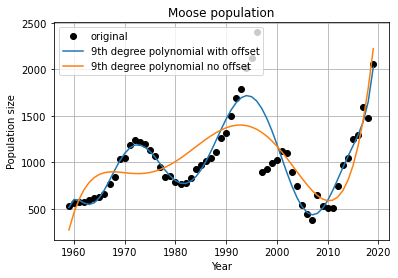

In [24]:
plt.plot(years, moose, 'o', color='black', label='original')
plt.plot(years, yi2, '-', label='9th degree polynomial with offset')
plt.plot(years, yi, '-', label='9th degree polynomial no offset')

plt.xlabel('Year')
plt.ylabel('Population size')
plt.title('Moose population')

plt.legend()
plt.grid(True)

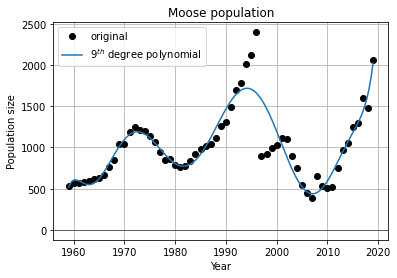

### Exercise 5

Below you find the average temperature in the city of Groningen across all months in a year (from: [Climates to travel](https://www.climatestotravel.com/climate/netherlands/groningen)).

| Month     | T [°C] |   | Month     | T [°C] |
| --------- | ------ | - | --------- | ------ |
| January   |  2.5   |   | July      | 17.5   |
| February  |  2.9   |   | August    | 17.2   |
| March     |  5.5   |   | September | 14.2   |
| April     |  8.9   |   | October   | 10.2   |
| May       | 12.4   |   | November  |  6.1   |
| June      | 15.1   |   | December  |  3.3   |

Because these data are periodic with a period of one year, they may be modeled by a linear model

$$
T(m) = T_\text{avg} + \Delta T_\text{cos} \cdot \cos(2\pi \frac{m}{12}) + \Delta T_\text{sin} \cdot \sin(2\pi \frac{m}{12})
$$

where $m$ is the number of the month, and coefficients $T_\text{avg}$, $\Delta T_\text{cos}$, and $\Delta T_\text{sin}$ are unknown. Plot these data together with the model's sinusoidal curve fit. What is the average temperature in Groningen, according to this model?

In [47]:
xi = np.arange(0, 12)
yi = np.array([2.5, 2.9, 5.5, 8.9, 12.4, 15.1, 17.5, 17.2, 14.2, 10.2, 6.1, 3.3])

X = np.vstack((np.ones(xi.size), np.cos(2 * np.pi *xi/12), np.sin(2 * np.pi * xi/12))).T
M = X.T @ X
v = X.T @ yi

a = np.linalg.solve(M, v)
a

array([ 9.65      , -7.51721051, -0.77141016])

In [55]:
x = np.linspace(-2, 13, 101)
y = a[0] + a[1] * np.cos(2 * np.pi * x / 12) + a[2] * np.sin(2 * np.pi * x /12)

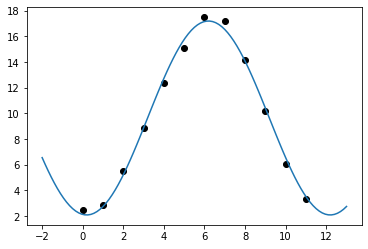

In [57]:
plt.plot(xi, yi, 'ok')
plt.plot(x, y)

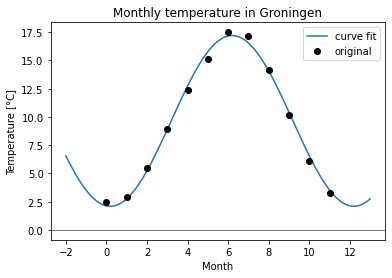

Tavg =  9.7 °C


### <a id="/6">Lesson 3 - Curve fitting</a>

* <span style="color:#336699"><a href="#/1">Part 3A</a><br />Introduction</span>

* <u>Part 3B</u><br />*Polynomial regression*

* <span style="color:#336699"><a href="#/11">Part 3C</a><br />Confidence intervals</span>

* <span style="color:#336699"><a href="#/16">Part 3D</a><br />Savitsky-Golay</span>

### Simple linear regression

[Simple linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression) fits a *linear* polynomial through data points $(x_i, y_i)$. The model equals

$$
y(x) = a_1 x + a_0
$$

Therefore, the residuals equal $e_i = y_i - y(x_i) = y_i - a_1 x_i - a_0$, and their sum of squares amounts to

$$
S = \sum_{i=1}^n (y_i - a_1 x_i - a_0)^2
$$

Taking the partial derivatives of $S$ with respect to $a_0$ and $a_1$, we obtain

$$
\begin{aligned}
\frac{\partial S}{\partial a_1} &= \sum_{i=1}^n -2 x_i (y_i - a_1 x_i - a_0)
\\
\frac{\partial S}{\partial a_0} &= \sum_{i=1}^n -2 (y_i - a_1 x_i - a_0)
\end{aligned}
$$

The mimimal sum of squared residuals $S$ is reached when these derivatives equal zero. This results in

$$
\begin{aligned}
\sum_{i=1}^n x_i y_i &= a_1 \sum_{i=1}^n x_i^2 + a_0 \sum_{i=1}^n x_i
\\
\sum_{i=1}^n y_i &= a_1 \sum_{i=1}^n x_i + a_0 \sum_{i=1}^n 1
\end{aligned}
$$

These are two linear equations in terms of two unknown parameters $a_1$ and $a_0$ that can be written as

$$
\left[\begin{array}{c}
\sum_i x_i y_i\\
\sum_i y_i
\end{array}\right] = \left[\begin{array}{cc}
\sum_i x_i^2 & \sum_i x_i\\
\sum_i x_i & n
\end{array}\right] \left[\begin{array}{c}
a_1\\
a_0
\end{array}\right]
$$

<small>**Note:** $\sum_i$ is shorthand for summation over all data points; $\sum_i 1$ equals $n$.</small>

This matrix equation can be solved using Gaussian elimination or Cramer's rule to find $\boldsymbol{a}$.

$$
\left\{
\begin{aligned}
a_1 &= \frac{n \sum_i x_i y_i - \sum_i x_i \cdot \sum_i y_i}{n \cdot \sum_i x_i^2 - \left( \sum_i x_i \right)^2}
\\
a_0 &= \frac{\sum_i x_i^2 \cdot \sum_i y_i - \sum_i x_i \cdot \sum_i x_i y_i}{n \cdot \sum_i x_i^2 - \left( \sum_i x_i \right)^2}
\end{aligned}
\right.
$$

### Polynomial regression

The general solution $\boldsymbol{a} = (\boldsymbol{X}^\text{T}\boldsymbol{X})^{-1} \cdot \boldsymbol{X}^\text{T} \boldsymbol{y}$ contains the inverse of the symmetric [Gram matrix](https://en.wikipedia.org/wiki/Gram_matrix) $\boldsymbol{M} = \boldsymbol{X}^\text{T}\boldsymbol{X}$ as well as the vector $\boldsymbol{v} = \boldsymbol{X}^\text{T} \boldsymbol{y}$. For polynomials, $\boldsymbol{X}$ is a [Vandermonde matrix](https://en.wikipedia.org/wiki/Vandermonde_matrix), and these take the form

$$
\boldsymbol{M} = \left[\begin{array}{cccc}
\sum_i x_i^{2p} & \cdots & \sum_i x_i^{p+1} & \sum_i x_i^p \\
\vdots & \ddots & \vdots & \vdots\\
\sum_i x_i^{p+1} & \cdots & \sum_i x_i^2 & \sum_i x_i \\
\sum_i x_i^p & \cdots & \sum_i x_i & n
\end{array}\right]
\quad\text{and}\quad
\boldsymbol{v} = \left[\begin{array}{c}
\sum_i x_i^p y_i\\
\sum_i x_i^{p-1} y_i\\
\vdots\\
\sum_i x_i y_i\\
\sum_i y_i
\end{array}\right]
$$

where the index $i=1\ldots n$ runs over all data points. Therefore, every element of $\boldsymbol{M}$ is a sum of powers of $x_i$, together with a single factor $y_i$ for $\boldsymbol{v}$. This generalizes the form of the equation that was found for simple linear regression.

Once $\boldsymbol{M}$ and $\boldsymbol{v}$ are computed, the least-squares polynomial coefficients equal $\boldsymbol{a} = \boldsymbol{M}^{-1} \boldsymbol{v}$.

<small>**Note:** see also Eq. 3.23 on P.131 of *Numerical methods in engineering with python 3* (with slightly different notation).</small>

### Example

We wish to find the value $y(x)$ at $x=1$ of the linear polynomial curve fit through the points $(-1,2)$, $(0,2)$, $(1,-1)$, $(2,-2)$, and $(3,-1)$.

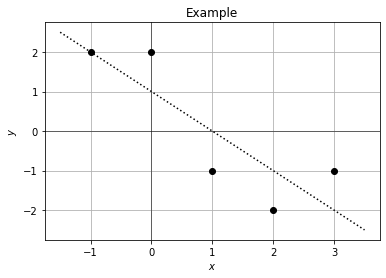

Figure 3: Example


In [19]:
figure(3)

The design matrix equals

$$
\boldsymbol{X} = \left[\begin{array}{cc}
-1 & 1\\
0 & 1\\
1 & 1\\
2 & 1\\
3 & 1
\end{array}\right]
$$

such that

$$
\boldsymbol{M} = \boldsymbol{X}^\text{T} \boldsymbol{X} = \left[\begin{array}{cc}
\sum_i x_i^2 & \sum_i x_i\\
\sum_i x_i & n
\end{array}\right] = \left[\begin{array}{cc}
15 & 5\\
5 & 5
\end{array}\right]
\quad\text{and}\quad
\boldsymbol{v} = \boldsymbol{X}^\text{T} \boldsymbol{y} = \left[\begin{array}{c}
\sum_i x_i y_i\\
\sum_i y_i
\end{array}\right] = \left[\begin{array}{c}
-10\\
0
\end{array}\right]
$$

We then need to solve $\boldsymbol{M} \boldsymbol{a} = \boldsymbol{v}$. For instance, using Gaussian elimination,

$$
\left[\begin{array}{cc|c}
15 & 5 & -10\\
5 & 5 & 0
\end{array}\right] \sim \left[\begin{array}{cc|c}
3 & 1 & -2\\
1 & 1 & 0
\end{array}\right] \sim \left[\begin{array}{cc|c}
1 & 0 & -1\\
0 & 1 & 1
\end{array}\right]
$$

Therefore, $\boldsymbol{a} = \left[\begin{array}{c}-1\\1\end{array}\right]$, and the linear curve fit equals

$$
y(x) = -x+1
$$

Hence, $y(1) = 0$.

In [146]:
xi = np.array([-1, 0, 1, 2, 3])
yi = np.array([2, 2, -1, -2, -1])

X = np.vander(xi, 2)
M = X.T @ X
v = X.T @ yi

a = np.linalg.inv(M) @ v

print(a)

round(np.polyval(a, 1), 2)

[-1.  1.]


-0.0

### Exercise 6

Determine the value $y(x)$ at $x=2$ of the linear polynomial curve fit through the points $(-3,-4)$, $(-2,-1)$, $(-1,3)$, $(0,1)$, $(1,7)$, $(2,7)$, and $(3,8)$.

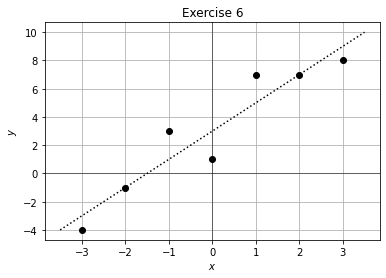

Figure 4: Exercise 6


In [20]:
figure(4)

In [149]:
xi = np.array([-3, -2, -1, 0, 1, 2, 3])
yi = np.array([-4, -1, 3, 1, 7, 7, 8])

X = np.vander(xi, 2)

M = X.T @ X
v = X.T @ yi

a = np.linalg.inv(M) @ v

# y(x) = 2x + 3
np.polyval(a, 2)

7.0

### Exercise 7

Complete the below skeleton function `poly_curvefit()` that interpolates between a number of given data points that are specified in arrays `xi` and `yi` using polynomial curve fitting, and calculates the $y$-values that correspond with all the $x$-values that are requested.

<small>**Note:** Write your own code that implements the described formulas; do *not* simply wrap the `polyfit()` or `lstsq()` function from `numpy` or `scipy`!</small>

<small>**Hint:** The functions `np.vander()`, `np.linalg.solve()` and `np.polyval()` may be useful to implement the described functionality.</small>

```python
def poly_curvefit(xi, yi, x, *, deg=1):
    """y = poly_curvefit(xi, yi, x, *, deg=1).
    Polynomial curve fitting method that fits a polynomial
    of given degree through data points {xi,yi}, evaluated
    at arguments x.
    xi     = {x1,x2,...,xn}
    yi     = {y1,y2,...,xn}
    x      = arguments x
    deg    = polynomial degree (default 1)
    """
    if xi.size != yi.size:
        raise ValueError('xi and yi must have the same length')
    if deg >= xi.size:
        raise ValueError('polynomial degree too high for available data')
    pass   # ADD YOUR OWN CODE HERE
    return y
```

In [39]:
def poly_curvefit(xi, yi, x, *, deg=1):
    """y = poly_curvefit(xi, yi, x, *, deg=1).
    Polynomial curve fitting method that fits a polynomial
    of given degree through data points {xi,yi}, evaluated
    at arguments x.
    xi     = {x1,x2,...,xn}
    yi     = {y1,y2,...,xn}
    x      = arguments x
    deg    = polynomial degree (default 1)
    """
    if xi.size != yi.size:
        raise ValueError('xi and yi must have the same length')
    if deg >= xi.size:
        raise ValueError('polynomial degree too high for available data')
    
    xi = xi.astype('float64')
    yi = yi.astype('float64')
    
    X = np.vander(xi, deg+1)
    
    M = X.T @ X
    v = X.T @ yi
    
    a = np.linalg.solve(M, v)
    
    y = np.polyval(a, x)
    
    return y

### Exercise 8

Apply your own function `poly_curvefit()` to determine $y(2)$ according to polynomial fits of degree 0 to 6 through the data of exercise 6.

How can you easily determine the answers for degrees 0 and 6 without linear algebra here?

In [40]:
xi = np.array([-3, -2, -1, 0, 1, 2, 3])
yi = np.array([-4, -1, 3, 1, 7, 7, 8])

for i in range(7):
    print('Degree {}: y(2.000) = {:.3f}'.format(i, poly_curvefit(xi, yi, 2, deg=i), 3))

Degree 0: y(2.000) = 3.000
Degree 1: y(2.000) = 7.000
Degree 2: y(2.000) = 7.000
Degree 3: y(2.000) = 7.000
Degree 4: y(2.000) = 7.636
Degree 5: y(2.000) = 7.636
Degree 6: y(2.000) = 7.000


Degree 0: y(2.000) = 3.000
Degree 1: y(2.000) = 7.000
Degree 2: y(2.000) = 7.000
Degree 3: y(2.000) = 7.000
Degree 4: y(2.000) = 7.636
Degree 5: y(2.000) = 7.636
Degree 6: y(2.000) = 7.000


### Exercise 9

Given the following data regarding the population size of the Netherlands (from: [Wikipedia](https://en.wikipedia.org/wiki/Demography_of_the_Netherlands#/Births_and_deaths)), plot the Dutch population size together with polynomial curve fits of degree 0 to 3 from the year 1900 until 2050 using your `poly_curvefit()` function.

| Year | Size       |   | Year | Size       |   | Year | Size       |
| ---- | ---------- | - | ---- | ---------- | - | ---- | ---------- |
| 1900 |  5,104,000 |   | 1950 | 10,026,773 |   | 2000 | 15,863,950 |
| 1910 |  5,858,000 |   | 1960 | 11,417,254 |   | 2010 | 16,574,989 |
| 1920 |  6,754,000 |   | 1970 | 12,957,621 |   | 2020 | 17,424,978 |
| 1930 |  7,825,000 |   | 1980 | 14,091,014 |   |      |            |
| 1940 |  8,834,000 |   | 1990 | 14,892,574 |   |      |            |

In [41]:
xi = np.arange(1900, 2030, 10)
yi = np.array([5104000, 5858000, 6754000, 7825000, 8834000, 10026773, 11417254, 12957621, 14091014, 14892574, 15863950, 16574989, 17424978])

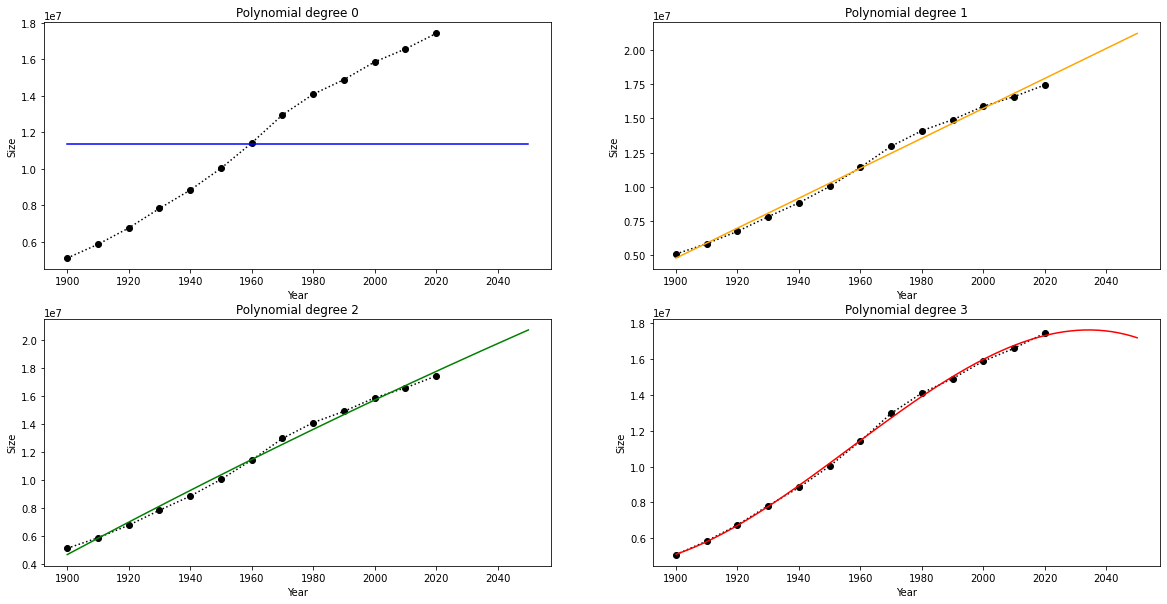

In [43]:
i, j = 0, 0
fig, axs = plt.subplots(2,2, figsize=(20, 10))

x = np.linspace(1900, 2050, 201)

colors = ['blue', 'orange', 'green', 'red']

for k in range(4):
    y = poly_curvefit(xi, yi, x, deg=k)
    
    axs[i][j].plot(xi, yi, 'o:k')
    axs[i][j].plot(x, y, '-', color=colors[k])
    
    axs[i][j].set_ylabel('Size')
    axs[i][j].set_xlabel('Year')
    axs[i][j].set_title('Polynomial degree {}'.format(k))
    j+=1

    if j==2:
        i+=1
        j=0
        
plt.show()

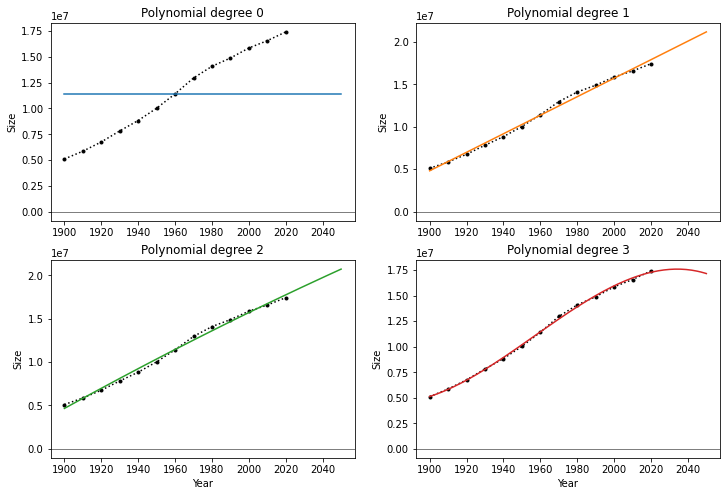

### <a id="/11">Lesson 3 - Curve fitting</a>

* <span style="color:#336699"><a href="#/1">Part 3A</a><br />Introduction</span>

* <span style="color:#336699"><a href="#/6">Part 3B</a><br />Polynomial regression</span>

* <u>Part 3C</u><br />*Confidence intervals*

* <span style="color:#336699"><a href="#/16">Part 3D</a><br />Savitsky-Golay</span>

### Standard error of regression

The spread of the data about the curve fit is quantified by the [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation) $\sigma_{y|x}$

$$
\sigma_{y|x} = \sqrt{\frac{S}{n-(p+1)}}
$$

where $p+1$ is the number of parameters of the model (i.e., $a_0$ to $a_p$). This is also known as the *standard error of regression*.

When $n = p+1$, polynomial curve fitting reduces to polynomial interpolation. In that case both the numerator and denominator become zero and $\sigma_{y|x}$ is indeterminate.

If the shape of the model fits the data, then the value of $\sigma_{y|x}$ can be regarded as an estimate of the [measurement error](https://en.wikipedia.org/wiki/Observational_error).

[Linear regression](https://en.wikipedia.org/wiki/Linear_regression) assumes that all deviations from the curve fit are caused by errors in the $y_i$; the $x_i$ are assumed to be exact.

Furthermore, residuals are assumed to be independent and identically distributed ([IID](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables)).

In the case of normally distributed residuals, this implies

$$
e_i \sim \mathcal{N}(0,\sigma_{y|x}^2)
$$

or, in vector form,

$$
\boldsymbol{e} \sim \mathcal{N}(\boldsymbol{0},\sigma_{y|x}^2\boldsymbol{I})
$$

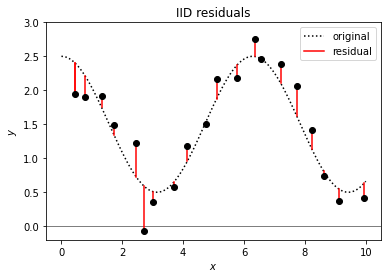

Figure 5: IID residuals


In [24]:
figure(5)

### Standard errors of predictions

If the standard deviation of the residuals is $\sigma_{y|x}$, then the covariance matrix $\boldsymbol{\Sigma}$ of the estimated model coefficients $a_j$ can be shown to equal

$$
\boldsymbol{\Sigma} = \sigma_{y|x}^2 (\boldsymbol{X}^\text{T} \boldsymbol{X})^{-1}
$$

$\boldsymbol{\Sigma}$ is a square [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix). Its diagonal elements contain the [variances](https://en.wikipedia.org/wiki/Variance) $\sigma_j^2$ of the coefficients $a_j$. Therefore, the standard errors of all coefficients can be calculated as the square root of the diagonal elements
 
$$
\sigma_j = \sqrt{\Sigma_{jj}}
$$

This can be used to deduce the 95% confidence interval $a_j \pm \text{CI}_j$ based on a Student's $t$-distribution with $n-(p+1)$ degrees of freedom.

$$
\text{CI}_j = t_{n-(p+1)}^{1-\alpha/2} \cdot \sigma_j
$$

<small>**Note:** see also Ch. 3 of *Data Science 1 - Frequentist and Bayesian Estimation and Statistics* (with slightly different notation).</small>

We can form any linear combination of the coefficients $a_j$ to obtain a scalar outcome $y$.

$$
y = \boldsymbol{c} \cdot \boldsymbol{a} = c_0 \cdot a_0 + c_1 \cdot a_1 + \ldots + c_p \cdot a_p
$$

The coefficients $\boldsymbol{c}$ are sometimes known as a [contrast vector](https://en.wikipedia.org/wiki/Contrast_(statistics)). Since the coefficients have uncertainties, also the outcome $y$ has an uncertainty. Its variance turns out to equal

$$
\sigma_y^2 = \boldsymbol{c}^\text{T}\boldsymbol{\Sigma}\boldsymbol{c}
$$

By taking the square root, the [standard error](https://en.wikipedia.org/wiki/Standard_error) $\sigma_y$ is obtained.

Interestingly, when computing model predictions $y(x)$ for given $x$, a linear combination is taken. For instance, for a polynomial curve fit, $y(x) = a_p x^p + \ldots + a_1 x + a_0$. Therefore, the powers of $x$ act as the coefficients: $\boldsymbol{c} = \left[ x^p, \ldots, x, 1 \right]$. 

For the various measured data points, the coefficients $\boldsymbol{c} = \left[ x_i^p, \ldots, x_i, 1 \right]$ can be found in the rows of the design matrix $\boldsymbol{X}$. As a result, the variances of all predictions $y(x_i)$ occur on the diagonal of the matrix $\boldsymbol{X}\boldsymbol{\Sigma}\boldsymbol{X}^\text{T}$.

This allows us to compute the uncertainties in the model predictions and plot them in the form of a [confidence band](https://en.wikipedia.org/wiki/Confidence_and_prediction_bands).

The figure shows the confidence band for the quadratic curvefit without intercept on the SARS-Covid-19 data.

<small>**Note:** The residuals in this example are certainly not IID, so strictly speaking the assumptions of linear regression are violated.</small>

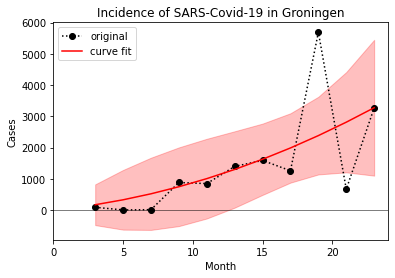

In [25]:
from scipy.stats import t
X = np.vstack((months ** 2, months)).T
M = X.T @ X
v = X.T @ cases
a = np.linalg.solve(M, v)
y = X @ a
e = cases - y
σ2 = sum(e ** 2) / (4 - 2)
Σ = σ2 * np.linalg.inv(M)
SE = np.sqrt(np.diag(X @ Σ @ X.T))
CI = t.ppf(0.975, 11 - 2) * SE

plt.axhline(0.0, color='k', lw=0.5)
plt.plot(months, cases, 'o:k', label='original')
plt.plot(months, y, '-r', label='curve fit')
plt.fill_between(months, y-CI, y+CI, color='r', alpha=0.25)
plt.xlabel('Month'); plt.ylabel('Cases')
plt.title('Incidence of SARS-Covid-19 in Groningen')
plt.legend(); plt.xlim(0.0, 24.0); plt.show()

### Example

We wish to find the confidence intervals of the coefficients $a_1 = -1$ and $a_0 = 1$, as well as the uncertainty in the prediction of $y(x)$ at $x=1$, for the linear polynomial curve fit through the points $(-1,2)$, $(0,2)$, $(1,-1)$, $(2,-2)$, and $(3,-1)$.

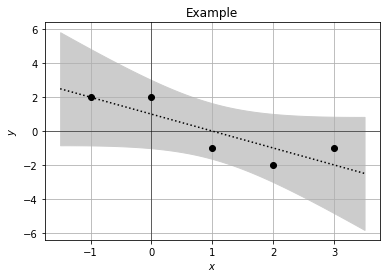

Figure 6: Example


In [26]:
figure(6)

In [175]:
deg = 1
order = deg + 1

xi = np.array([-1, 0, 1, 2, 3])
yi = np.array([2, 2, -1, -2, -1])

X = np.vander(xi, order)

M = X.T @ X
v = X.T @ yi

a = np.linalg.solve(M, v)
a

array([-1.,  1.])

For $x_i$ in $\left[ -1, 0, 1, 2, 3 \right]$, the predictions $y(x) = 1-x$ equal $\left[ 2, 1, 0, -1, -2 \right]$, whereas the measurements $y_i$ equal $\left[ 2, 2, -1, -2, -1 \right]$. Therefore, the errors $e_i = y_i-y(x_i)$ equal $\left[ 0, 1, -1, -1, 1 \right]$. As a result, $S = 0^2 + 1^2 + (-1)^2 + (-1)^2 + 1^2 = 4$, and $\sigma_{y|x}^2 = \frac{4}{5-2}$.

The covariance matrix of the estimated model coefficients equals

$$
\boldsymbol{\Sigma} = \sigma_{y|x}^2 (\boldsymbol{X}^\text{T} \boldsymbol{X})^{-1} = \frac{4}{3} \left[\begin{array}{cc}
15 & 5\\
5 & 5
\end{array}\right]^{-1} = \frac{2}{15} \left[\begin{array}{cc}
1 & -1\\
-1 & 3
\end{array}\right]
$$

Hence, the standard errors on the diagonal amount to $\sigma_1 = \sqrt{\frac{2}{15}}$ and $\sigma_0 = \sqrt{\frac{2}{5}}$. Therefore, the confidence intervals equal

* for $a_1$: $-1 \pm t_3^{0.975} \cdot \sigma_1 = -1.00 \pm 1.16$

* for $a_0$: $\phantom{-}1 \pm t_3^{0.975} \cdot \sigma_0 = \phantom{-}1.00 \pm 2.01$

<small>**Note:** $t_3^{0.975} \approx 3.18$.</small>

In [184]:
from scipy.stats import t

In [188]:
# prediction
y = np.polyval(a, xi)

# errors
e = yi - y

# Sum of squared errors
SSE = sum(e**2)

# variance
var = SSE / (xi.size - order)

# covariance matrix
M = X.T @ X
covar = var * np.linalg.inv(M)

# standard error
s = np.sqrt(np.diag(covar))

# confidence intervals
alpha = 0.05
ci = -t.ppf(alpha/2, xi.size-order) * s

Finally, $y(1)=1 \cdot a_1 + a_0$ so $\boldsymbol{c} = \left[1,1\right]^\text{T}$. Then

$$
\sigma_y^2(1) = \frac{2}{15} \left[\begin{array}{cc}
1 & 1
\end{array}\right] \left[\begin{array}{cc}
1 & -1\\
-1 & 3
\end{array}\right] \left[\begin{array}{c}
1\\1
\end{array}\right] = \frac{4}{15}
$$

Therefore, the standard error of the prediction $y(1)=0$ equals $\sqrt{\frac{4}{15}}$, and the confidence interval is

* for $y(1)$: $0 \pm t_3^{0.975} \cdot \sqrt{\frac{4}{15}} = 0.00 \pm 1.64$

In [189]:
x = np.array([1])

vander = np.vander(x, 2)
err = np.sqrt(np.sum(vander @ covar * vander, axis=1))

-t.ppf(alpha/2, 3) * err

array([1.64340821])

### Exercise 10

Manually determine the confidence intervals of the coefficients $a_1$ and $a_0$, as well as the uncertainty in the prediction of $y(x)$ at $x=2$, for the linear polynomial curve fit through the points $(-3,-4)$, $(-2,-1)$, $(-1,3)$, $(0,1)$, $(1,7)$, $(2,7)$, and $(3,8)$.

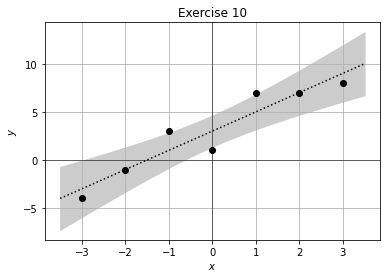

Figure 7: Exercise 10


In [27]:
figure(7)

### Exercise 11

Extend your function `poly_curvefit()` from exercise 7 such that it also returns the lower and upper bound of the two-sided confidence band for all `x` values if the user supplies an additional confidence level parameter `alpha` (for example, $\alpha = 0.05$); if no `alpha` is provided, the function should only return the values `y` for the curve fit itself.

```python
def poly_curvefit(xi, yi, x, *, deg=1, alpha=None):
    """y, lower, upper = poly_curvefit(xi, yi, x, *, deg=1, alpha=None).
    Polynomial curve fitting method that fits a polynomial
    of given degree through data points {xi,yi}, evaluated
    at arguments x. If a confidence level is provided, the
    lower and upper bounds of the confidence interval for
    all y is also returned.    
    xi     = {x1,x2,...,xn}
    yi     = {y1,y2,...,xn}
    x      = arguments x
    deg    = polynomial degree (default 1)
    alpha  = confidence level (default None)
    """
    if xi.size != yi.size:
        raise ValueError('xi and yi must have the same length')
    if deg >= xi.size:
        raise ValueError('polynomial degree too high for available data')
    if alpha is not None and not 0.0 < alpha < 1.0:
        raise ValueError('confidence level must lie between 0.0 and 1.0')
    pass   # ADD YOUR OWN CODE HERE
    if alpha is None:
        return y
    pass   # ADD YOUR OWN CODE HERE
    return y, lower, upper
```

In [190]:
def poly_curvefit(xi, yi, x, *, deg=1, alpha=None):
    """y, lower, upper = poly_curvefit(xi, yi, x, *, deg=1, alpha=None).
    Polynomial curve fitting method that fits a polynomial
    of given degree through data points {xi,yi}, evaluated
    at arguments x. If a confidence level is provided, the
    lower and upper bounds of the confidence interval for
    all y is also returned.    
    xi     = {x1,x2,...,xn}
    yi     = {y1,y2,...,xn}
    x      = arguments x
    deg    = polynomial degree (default 1)
    alpha  = confidence level (default None)
    """
    if xi.size != yi.size:
        raise ValueError('xi and yi must have the same length')
    if deg >= xi.size:
        raise ValueError('polynomial degree too high for available data')
    if alpha is not None and not 0.0 < alpha < 1.0:
        raise ValueError('confidence level must lie between 0.0 and 1.0')
    
    order = deg + 1
    
    xi = xi + 0.0
    yi = yi + 0.0
    
    X = np.vander(xi, order)
        
    M = X.T @ X
    v = X.T @ yi

    coef = np.linalg.solve(M, v)
    
    y = np.polyval(coef, x)
    
    if alpha is None:
        return y
    
    dof = xi.size - deg - 1
    variance = np.sum((yi - np.polyval(coef, xi)) ** 2) / dof
    covariance = variance * np.linalg.inv(X.T @ X)
    
    vander = np.vander(x, order)
    error = np.sqrt(np.sum(vander @ covariance * vander, axis=1))
    tvalue = -t.ppf(alpha / 2.0, dof)
    
    return y, (y - tvalue * error), (y + tvalue * error)

### Exercise 12

Apply your own function `poly_curvefit()` to determine the confidence intervals of $y(2)$ according to polynomial fits of degree 0 to 5 through the data from exercise 10.

Why is degree 6 omitted here? For which degree polynomial is the confidence interval of the prediction the narrowest?

In [191]:
xi = np.array([-3, -2, -1, 0, 1, 2, 3])
yi = np.array([-4, -1, 3, 1, 7, 7, 8])

In [192]:
for i in range(6):
    y, lowerbound, upperbound = poly_curvefit(xi, yi, [2], deg=i, alpha=0.05)
    
    print('Degree {}: y(2.000) = {:.3f} ± {:.3f}'.format(i, y[0], (y-lowerbound)[0]))

Degree 0: y(2.000) = 3.000 ± 4.238
Degree 1: y(2.000) = 7.000 ± 2.299
Degree 2: y(2.000) = 7.000 ± 2.535
Degree 3: y(2.000) = 7.000 ± 4.221
Degree 4: y(2.000) = 7.636 ± 8.610
Degree 5: y(2.000) = 7.636 ± 40.158


Degree 0: y(2.000) = 3.000 ± 4.238
Degree 1: y(2.000) = 7.000 ± 2.299
Degree 2: y(2.000) = 7.000 ± 2.535
Degree 3: y(2.000) = 7.000 ± 4.221
Degree 4: y(2.000) = 7.636 ± 8.610
Degree 5: y(2.000) = 7.636 ± 40.158


### Exercise 13

Extend your solution to exercise 9 by also shading confidence bands.

Which polynomial degree 0 to 3 fits the existing data closest? And which polynomial degree 0 to 3 leads to the narrowest confidence interval for the predicted population size in 2050?

In [193]:
xi = np.arange(1900, 2030, 10)
yi = np.array([5104000, 5858000, 6754000, 7825000, 8834000, 10026773, 11417254, 12957621, 14091014, 14892574, 15863950, 16574989, 17424978])

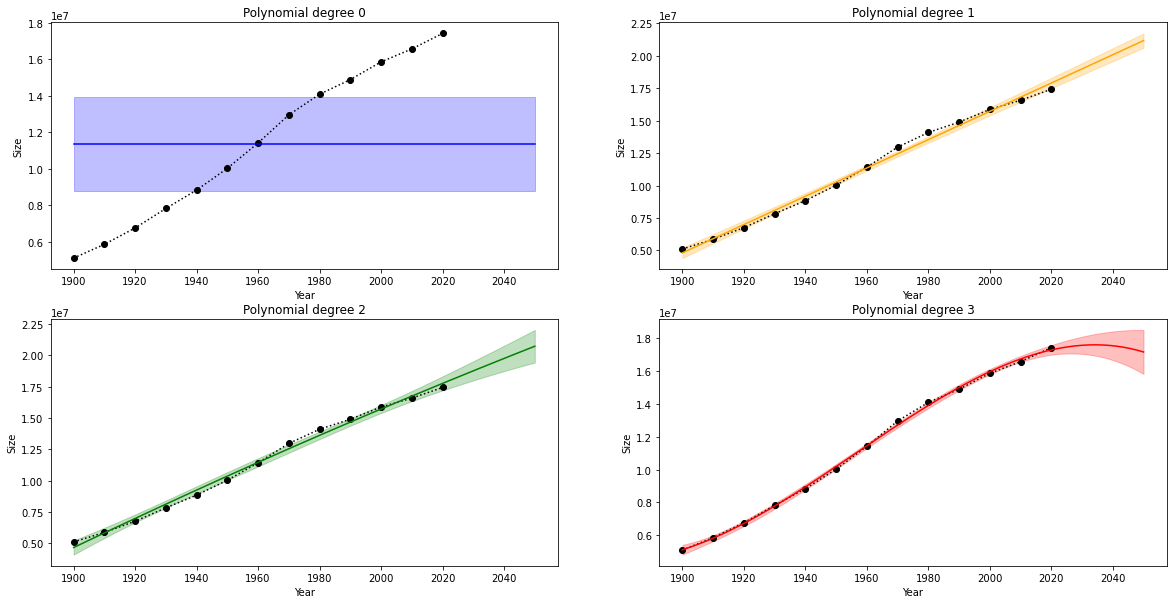

In [194]:
i, j = 0, 0
fig, axs = plt.subplots(2,2, figsize=(20, 10))

x = np.linspace(1900, 2050, 201)

colors = ['blue', 'orange', 'green', 'red']

for k in range(4):
    y, lowerbound, upperbound = poly_curvefit(xi, yi, x, deg=k, alpha=0.05)
    
    axs[i][j].plot(xi, yi, 'o:k')
    axs[i][j].plot(x, y, '-', color=colors[k])
    axs[i][j].fill_between(x, lowerbound, upperbound, color=colors[k], alpha=0.25)
    
    axs[i][j].set_ylabel('Size')
    axs[i][j].set_xlabel('Year')
    axs[i][j].set_title('Polynomial degree {}'.format(k))
    j+=1

    if j==2:
        i+=1
        j=0
        
plt.show()

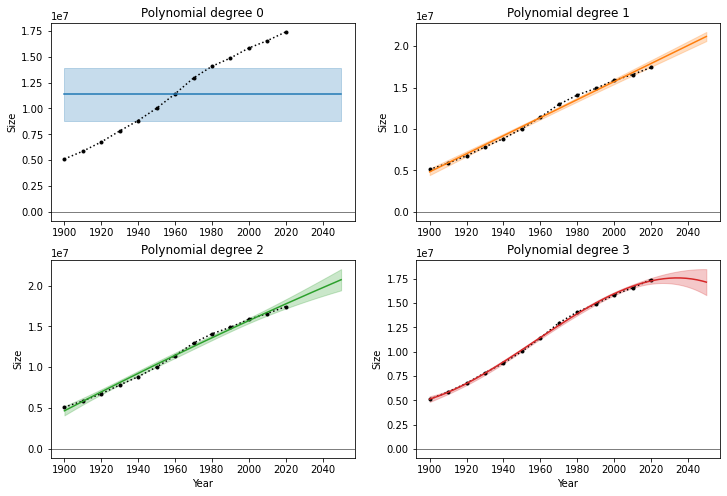

### <a id="/16">Lesson 3 - Curve fitting</a>

* <span style="color:#336699"><a href="#/1">Part 3A</a><br />Introduction</span>

* <span style="color:#336699"><a href="#/6">Part 3B</a><br />Polynomial regression</span>

* <span style="color:#336699"><a href="#/11">Part 3D</a><br />Confidence intervals</span>

* <u>Part 3D</u><br />*Savitsky-Golay*

### Local windowing

Although curve fitting is less sensitive to [Runge's phenomenon](https://en.wikipedia.org/wiki/Runge%27s_phenomenon) than global interpolation, it may be useful to apply regression methods locally by [windowing](https://en.wikipedia.org/wiki/Window_function) the available data points.

The rationale behind windowing is that distant data points should not influence the curve fit at a particular location. Therefore, only a limited number of data points close to the value of $x$ of interest are considered.

<small>**Note:** a window may gradually decrease the weight of data points towards its edge, called [apodization](https://en.wikipedia.org/wiki/Apodization); we will only consider unweighted rectangular ([boxcar](https://en.wikipedia.org/wiki/Boxcar_function)) windows.</small>

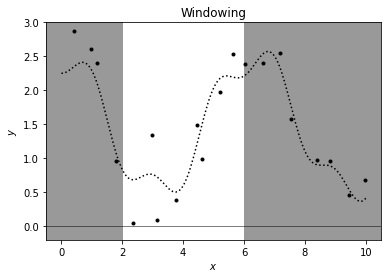

Figure 8: Windowing


In [31]:
figure(8)

In the figure, y(4) is estimated. Here, only the window from $x=2$ to $x=6$ is taken into account (in red); all data outside this window (in black) is rejected.

A quadratic polynomial is fitted to the data inside the window. This polynomial is used to estimate the value $y(x)$ at $x=4$.

Note that for other $x$, different sets of data points will contribute towards the curve fit.

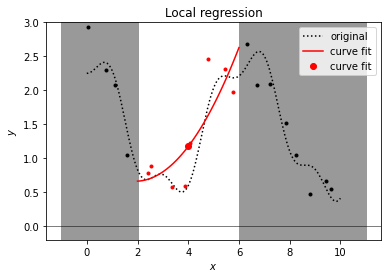

Figure 9: Local regression


In [32]:
figure(9)

### Savitsky-Golay

The [Savitsky-Golay](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) method imposes windowing on polynomial curve fitting.

It is determined by the following parameters.

* The window size $w$<br />
  This can either be specified by a half-window size $\Delta x$ such that all data points for which $|x_i - x| \leq \Delta x$ are included, or by an integer $N$ that denotes the total number of nearest neighboring data points that should be included.

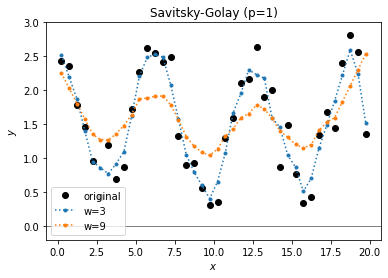

Figure 10: Savitsky-Golay (p=1)


In [33]:
figure(10)

* The polynomial degree $p$<br />
  The higher the polynomial degree, the more oscillatory behavior the polynomial will be able to model. For a 0<sup>th</sup> degree polynomial, the method will amount to a [moving average](https://en.wikipedia.org/wiki/Moving_average).
  
As a rule of thumb, complexer dynamic signals can be captured by choosing a smaller window size or a higher polynomial degree. At the same time, this will make the method more sensitive to noise.

It is common to choose moderate window sizes that include a substantial number of data points and fairly low polynomial degrees (e.g. 2).

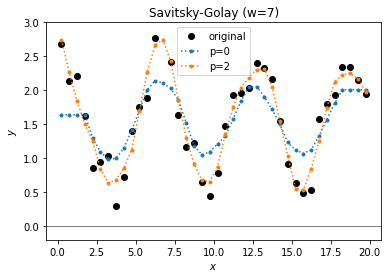

Figure 11: Savitsky-Golay (w=7)


In [34]:
figure(11)

The `scipy.signal` module contains the `savgol_filter()` function. However, this has a number of limitations.

* The function is applied to the same $x_i$ that were provided as data points. As a result, an existing signal can be smoothed, but not interpolated or extrapolated to new $x$ values.

* The data points are assumed to be equidistant, i.e. the $x_i$ are regularly spaced.

* The window size $w$ must be an odd integer to avoid ties between equally spaced points on the left and right.

These limitations allow a number of optimizations. Here we will overlook these for now.

### Related methods

There are a number of closely related local curve fitting methods. In particular:

* [segmented regression](https://en.wikipedia.org/wiki/Segmented_regression) consists of separate regression models that are applied in distinct pre-defined partitions of $x$. This leads to a piecewise function. In contrast to splines, each individual segment can be fitted through many data points.<br />
  Segmented regression can be carried out using the `np.lstsq()` function by providing segmented basis functions in the design matrix $\boldsymbol{X}$.

* [kernel smoothing](https://en.wikipedia.org/wiki/Kernel_smoother) and [LOESS- and LOWESS regression](https://en.wikipedia.org/wiki/Local_regression) not only apply a window (to a polynomial of degree 0, 1 or 2, respectively), but also use a weighting function in which the data points at the edges of the window are weighted less than those in its center. This leads to more a smoothly varying curve fit $y(x)$.<br />
  These methods are not available in `numpy`, `scipy`, or `pandas`, but can be implemented by adding weighting to the Savitsky-Golay method.

### Example

We wish to find $y(x)$ at $x=\frac{2}{3}$, for the Savitsky-Golay curve fit through the points $(-1,2)$, $(0,2)$, $(1,-1)$, $(2,-2)$, and $(3,-1)$ with a window size of 3 data points and a polynomial degree 1.

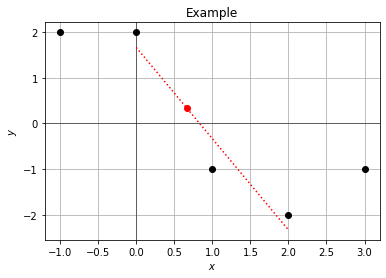

Figure 12: Example


In [35]:
figure(12)

The three data points with the smallest distance to $x=\frac{2}{3}$ are $(0,2)$, $(1,-1)$, and $(2,-2)$. Therefore, we construct a linear curve fit through these points.

The design matrix equals $\boldsymbol{X} = \left[\begin{array}{cc}
0 & 1\\
1 & 1\\
2 & 1
\end{array}\right]
$ such that

$$
\boldsymbol{M} = \boldsymbol{X}^\text{T} \boldsymbol{X} = \left[\begin{array}{cc}
\sum_i x_i^2 & \sum_i x_i\\
\sum_i x_i & n
\end{array}\right] = \left[\begin{array}{cc}
5 & 3\\
3 & 3
\end{array}\right]
\quad\text{and}\quad
\boldsymbol{v} = \boldsymbol{X}^\text{T} \boldsymbol{y} = \left[\begin{array}{c}
\sum_i x_i y_i\\
\sum_i y_i
\end{array}\right] = \left[\begin{array}{c}
-5\\
-1
\end{array}\right]
$$

Solving $\boldsymbol{M} \boldsymbol{a} = \boldsymbol{v}$ using Gaussian elimination,

$$
\left[\begin{array}{cc|c}
5 & 3 & -5\\
3 & 3 & -1
\end{array}\right] \sim \left[\begin{array}{cc|c}
1 & 0 & -2\\
0 & 1 & \frac{5}{3}
\end{array}\right]
$$

Therefore, $y(x) = -2x+\frac{5}{3}$ and $y(\frac{2}{3}) = \frac{1}{3}$.

In [195]:
xi = np.array([-1, 0, 1, 2, 3]) 
yi = np.array([2, 2, -1, -2, -1])

xi = xi + 0.0
yi = yi + 0.0

window = 3
deg = 1
order = deg + 1

x = 2/3

# if window is an integer
# make a collection of index: value
distance = np.abs(xi - x)
collection = [(i, distance[i]) for i in range(xi.size)]
collection = sorted(collection, key=lambda x: x[1])
x_neighbours_idx = sorted([k for k, v in collection[:window]])
x_neighbours = [xi[key] for key in x_neighbours_idx]
y_neighbours = [yi[key] for key in x_neighbours_idx]

X = np.vander(x_neighbours, order)
M = X.T @ X
v = X.T @ y_neighbours

a = np.linalg.solve(M, v)
np.polyval(a, x)

0.33333333333333326

### Exercise 14

Manually determine the value $y(x)$ at $x=2$, for the Savitsky-Golay curve fit through the points $(-3,-4)$, $(-2,-1)$, $(-1,3)$, $(0,1)$, $(1,7)$, $(2,7)$, and $(3,8)$ with a window half-size of $\Delta x = 2.5$ and a polynomial degree 1.

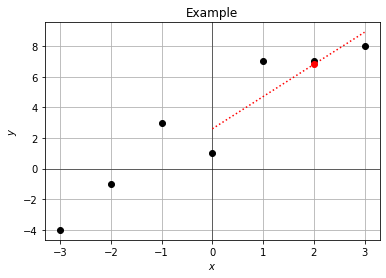

Figure 13: Example


In [36]:
figure(13)

In [196]:
xi = np.array([-3, -2, -1, 0, 1, 2, 3]) 
yi = np.array([-4, -1, 3, 1, 7, 7, 8])

xi = xi + 0.0
yi = yi + 0.0

window = 2.5
deg = 1
order = deg + 1

x = 2

distance = np.abs(xi - x)
collection = [(i, distance[i]) for i in range(xi.size)]
collection = sorted(collection, key=lambda x: x[1])

# half window
x_neighbours_idx = sorted([k for k, v in collection if v < window])
x_neighbours = [xi[key] for key in x_neighbours_idx]
y_neighbours = [yi[key] for key in x_neighbours_idx]

X = np.vander(x_neighbours, order)
M = X.T @ X
v = X.T @ y_neighbours

a = np.linalg.solve(M, v)
np.polyval(a, x)

6.800000000000001

### Exercise 15

Complete the below skeleton function `savgol_curvefit()` that fits a polynomial curve of requested degree through given data points $(x_i, y_i)$, and calculates the $y$-values that correspond with all $x$-values. A window parameter `w` should be provided by the user either in the form of a floating-point value (in which case it denotes the half-window size $\Delta x$), or in the case of a positieve integer value (in which case it denotes the number of nearest neighbors $N$ to take into account).

```python
def savgol_curvefit(xi, yi, x, *, deg=1, window=5):
    """y = savgol_curvefit(xi, yi, x, *, deg, window).
    Savitsky-Golay method that fits local polynomials
    of given degree through data points {xi,yi} that
    fall in a window centered on x, evaluated
    at arguments x. The window size is specified either
    as a float indicating the half-window size, or as
    an int indicating the number of data points.
    xi     = {x1,x2,...,xn}
    yi     = {y1,y2,...,xn}
    x      = arguments x
    deg    = polynomial degree (default 1)
    window = window size as float/int (default 5)
    """
    if xi.size != yi.size:
        raise ValueError('xi and yi must have the same length')
    pass   # ADD YOUR OWN CODE HERE
    return y
```

In [202]:
def savgol_curvefit(xi, yi, x, *, deg=1, window=5):
    """y = savgol_curvefit(xi, yi, x, *, deg, window).
    Savitsky-Golay method that fits local polynomials
    of given degree through data points {xi,yi} that
    fall in a window centered on x, evaluated
    at arguments x. The window size is specified either
    as a float indicating the half-window size, or as
    an int indicating the number of data points.
    xi     = {x1,x2,...,xn}
    yi     = {y1,y2,...,xn}
    x      = arguments x
    deg    = polynomial degree (default 1)
    window = window size as float/int (default 5)
    """
    if xi.size != yi.size:
        raise ValueError('xi and yi must have the same length')
        
    if not isinstance(x, (list, np.ndarray)):
        raise ValueError('x must be a numpy array!')
        
    res = np.empty(x.size)
    
    xi = xi.astype('float64')
    yi = yi.astype('float64')

    order = deg + 1
    
    for n, val in enumerate(x):
        # xi = [1, 2, 3, 4, 5, 6]
        # x = 3
        # np.abs(xi - x) -> [2, 1, 0, 1, 2, 3]
        distance = np.abs(xi - val)
        collection = [(i, distance[i]) for i in range(xi.size)] # [(0, 2), (1, 1), (2, 0), (3, 1), (4, 2), (5, 3)]
        collection = sorted(collection, key=lambda x: x[1]) # [(2, 0), (1, 1), (3, 1), (0, 2), (4, 2), (5, 3)]
    
        # nearest neighbours
        if isinstance(window, int):
            x_neighbours_idx = sorted([k for k, v in collection[:window]])
        else:
            # half window
            x_neighbours_idx = sorted([k for k, v in collection if v < window])

        x_neighbours = [xi[key] for key in x_neighbours_idx]
        y_neighbours = [yi[key] for key in x_neighbours_idx]
    
        X = np.vander(x_neighbours, order)
        M = X.T @ X
        v = X.T @ y_neighbours

        a = np.linalg.solve(M, v)

        res[n] = np.polyval(a, val)
    
    return res


### Exercise 16

Apply your own function `savgol_curvefit()` to verify your solution for exercise 14.

In [203]:
xi = np.array([-3, -2, -1, 0, 1, 2, 3]) 
yi = np.array([-4, -1, 3, 1, 7, 7, 8])

savgol_curvefit(xi, yi, x=np.array([2]), deg=1, window=2.5)

array([6.8])

y(2.000) = 6.800


### Exercise 17

Modify your solution to exercise 9 by using the Savitsky-Golay method instead of regular polynomial curve fitting. Try various polynomial degrees and window sizes.

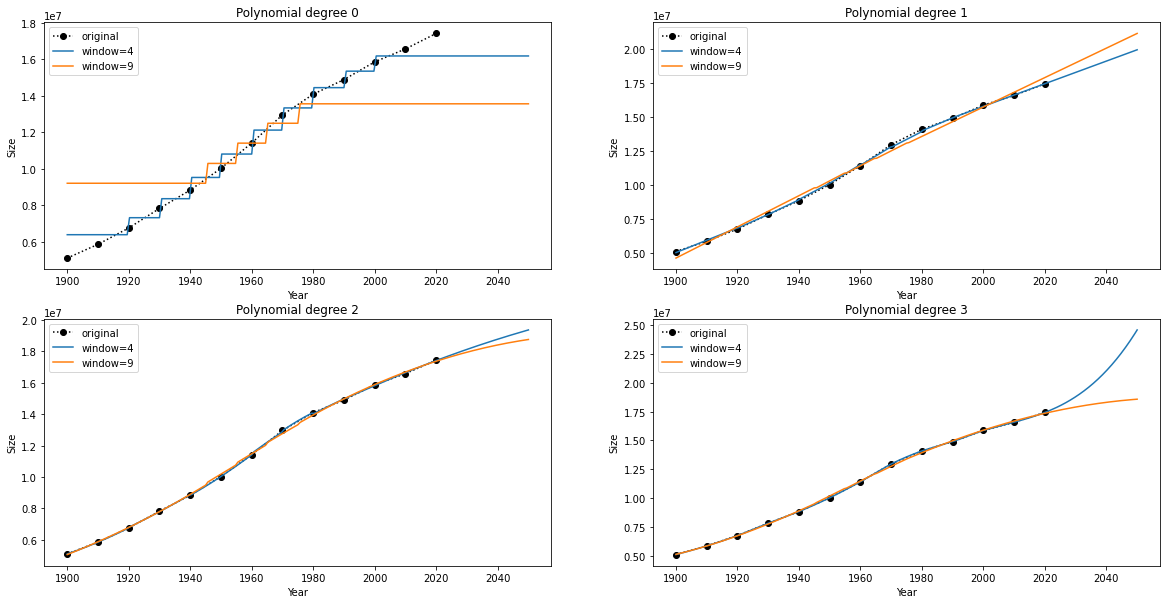

In [204]:
xi = np.arange(1900, 2030, 10)
yi = np.array([5104000, 5858000, 6754000, 7825000, 8834000, 10026773, 11417254, 12957621, 14091014, 14892574, 15863950, 16574989, 17424978])

i, j = 0, 0
fig, axs = plt.subplots(2,2, figsize=(20, 10))

x = np.linspace(1900, 2050, 201)

for k in range(4):
    y_4 = savgol_curvefit(xi, yi, x, deg=k, window=4)
    y_9 = savgol_curvefit(xi, yi, x, deg=k, window=9)
    
    axs[i][j].plot(xi, yi, 'o:k', label='original')
    axs[i][j].plot(x, y_4, '-', label='window=4')
    axs[i][j].plot(x, y_9, '-', label='window=9')
    
    axs[i][j].set_ylabel('Size')
    axs[i][j].set_xlabel('Year')
    axs[i][j].set_title('Polynomial degree {}'.format(k))
    
    axs[i][j].legend()
    
    j+=1

    if j==2:
        i+=1
        j=0
        
plt.show()

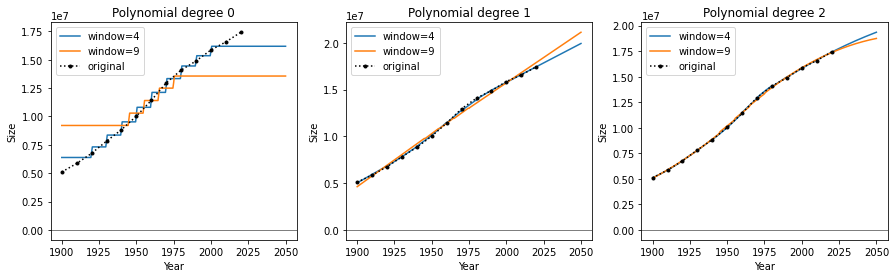

### End of lesson 3

Congratulations for finishing this lesson!

* Run your full notebook from scratch to ensure it works correctly (i.e., `Kernel` > `Restart & Run All`).

* Save your working version (i.e., `File` > `Save and Checkpoint`).

* Submit your completed notebook on [BlackBoard](https://blackboard.hanze.nl).

If handed in on time, you will be provided with feedback on your implementation of the `savgol_curvefit()` function in **Part 3D**.

***